# ORTEGA write PPAs
* This notebook is used to generate trajectory into PPAs. The output dataframe is written as a parquet file.  
* Shapefile is written into another parquet seperately. 
* Renamed ```aggr_std_ellipse``` to ```geom_ppa``` for clarity

## Set up
Require an Esri ArcGIS GeoAnlytics Engine account, with username and password written in ```notebook.cfg```

In [1]:
# Set up secrets auth
from configparser import ConfigParser
parser = ConfigParser()
_ = parser.read('../../notebook.cfg')
gae_user = parser.get('Engine', 'user')
gae_pass = parser.get('Engine', 'auth')

In [2]:
# Imports
import geoanalytics
import geoanalytics.sql.functions as ST
import pyspark.sql.types as PyType

from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession, DataFrame, functions as F
import math

In [3]:
# Sign into GeoAnalytics Enginemail
geoanalytics.auth(username=gae_user, password=gae_pass)
print(f"GeoAnalytics v.{geoanalytics.version()} awesome is enabled")

GeoAnalytics v.1.2.0.1291 awesome is enabled


In [4]:
df = spark.read.csv(r"../Data/Vulture_context_status.csv", header=True)
df.count()

2233653

### Global settings

In [5]:
# Very large PPAs that were generated due to data gaps is defined as 
# "larger than three times the standard deviation of the sampling intervals", 
# so we set it to 60 + 3*24.95 = 135 mins
LARGE_TIME_DELTA = 8100 # in seconds; 135 min

timestamp_field = "study-local-timestamp"
longitude_field = "location-long"
latitude_field = "location-lat"
id_field = "individual-local-identifier"
num_field = "event-id"
speed_field = "speed"

# Earth radius in KM
R = 6371 # km

### Create PPA Parquet

In [6]:
print(f"Feature count: {df.persist().count()}")
df.printSchema()

Feature count: 2233653
root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- event-id: string (nullable = true)
 |-- visible: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- location-long: string (nullable = true)
 |-- location-lat: string (nullable = true)
 |-- algorithm-marked-outlier: string (nullable = true)
 |-- external-temperature: string (nullable = true)
 |-- gps:hdop: string (nullable = true)
 |-- gps:satellite-count: string (nullable = true)
 |-- gps-time-to-fix: string (nullable = true)
 |-- gps:vdop: string (nullable = true)
 |-- ground-speed: string (nullable = true)
 |-- gt:activity-count: string (nullable = true)
 |-- gt:sys-week: string (nullable = true)
 |-- gt:tx-count: string (nullable = true)
 |-- heading: string (nullable = true)
 |-- height-above-ellipsoid: string (nullable = true)
 |-- height-raw: string (nullable = true)
 |-- import-marked-outlier: string (nullable = true)
 |-- location-error-text: string 

In [7]:
# create timestamp & geometry
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df = df\
    .withColumnRenamed("timestamp", "timestamp_orig")\
    .withColumn("timestamp", F.to_timestamp(F.col(timestamp_field), "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("geometry", ST.srid(ST.point(longitude_field, latitude_field), 4326))

# proof of concept that both created correctly (e.g., not nulled)
df.select("timestamp", "geometry").show(5)

+-------------------+--------------------+
|          timestamp|            geometry|
+-------------------+--------------------+
|2018-06-05 19:00:00|{"x":-124.143,"y"...|
|2018-06-05 20:00:00|{"x":-124.1545,"y...|
|2018-06-05 21:00:00|{"x":-124.12483,"...|
|2018-06-05 22:00:00|{"x":-124.1245,"y...|
|2018-06-05 23:00:00|{"x":-124.125,"y"...|
+-------------------+--------------------+
only showing top 5 rows



### Process Environmental Variables
- NDVI, Temperature: interpolate if Nan
- Tailwind, Crosswind: generate from U/V wind and heading
- **Thermal uplift: will annotated from Movebank after getting all intersecting ellipses**, as the platform can only handle around 10,000 points for each file

In [8]:
# df.where(F.col("MODIS Land Vegetation Indices 250m 16d Terra NDVI").isNull()).count() #1866
# Fill missing values with zero
df = df.na.fill({'MODIS Land Vegetation Indices 250m 16d Terra NDVI': 0})
# Rename the NDVI column and cast it to double
# Rename temperature column
df = df.withColumn("NDVI", F.col("MODIS Land Vegetation Indices 250m 16d Terra NDVI").cast("double"))\
        .withColumn("Temp", F.col("ECMWF ERA5 SL Temperature (2 m above Ground)").cast("double"))\
        .drop("MODIS Land Vegetation Indices 250m 16d Terra NDVI", "ECMWF ERA5 SL Temperature (2 m above Ground)")

In [9]:
# Normalize heading to 0°-360° range and convert to radians
# Calculate tailwind and crosswind
df = df.withColumn("heading_rad", 
                   F.radians(F.col("heading").cast("long") % 360))\
       .withColumn("tailwind", 
                   - F.col("ECMWF ERA5 SL Wind (10 m above Ground U Component)") * F.sin(F.col("heading_rad"))
                   + F.col("ECMWF ERA5 SL Wind (10 m above Ground V Component)") * F.cos(F.col("heading_rad")))\
       .withColumn("crosswind",
                   F.col("ECMWF ERA5 SL Wind (10 m above Ground U Component)") * F.cos(F.col("heading_rad"))
                   - F.col("ECMWF ERA5 SL Wind (10 m above Ground V Component)") * F.sin(F.col("heading_rad")))\
        .drop("ECMWF ERA5 SL Wind (10 m above Ground U Component)", "ECMWF ERA5 SL Wind (10 m above Ground V Component)")

In [10]:
df.where(df.heading.isNull())\
                .groupBy(id_field)\
                .agg(F.count(F.lit(1)).alias("null_heading_count")).show()

+---------------------------+------------------+
|individual-local-identifier|null_heading_count|
+---------------------------+------------------+
|                 Butterball|              1769|
|                   Blizzard|              2197|
|                  Duck Lake|              2677|
|                     Disney|             20829|
|                      Ethan|              7129|
|                       Hugh|              9071|
|                       Irma|             14361|
|                        Leo|             18808|
|                    Morongo|             20752|
|                        Mac|             11896|
|                      Prado|             20966|
|                    Rosalie|             23931|
|                     Ranger|              2697|
|                 Schaumboch|              3323|
|                       Sill|              2696|
|                     Sarkis|              8960|
+---------------------------+------------------+



In [39]:
subdf = df.select(num_field, id_field, latitude_field, longitude_field, "timestamp", "geometry",
                  speed_field, "NDVI", "Temp", "tailwind", "crosswind")

## Calculate PPA

- speed valid: filter out delta_time > 3600, set them to zero
- weighted speed: multiply by weight, remove zero speed

In [40]:
from pyspark.sql.window import Window
from pyspark.sql.types import *

In [41]:
window = Window.partitionBy(id_field).orderBy("timestamp")
window_5 = Window.rowsBetween(-4, 0)

In [42]:
# add prev_ environmental data at this step as well
subdf = subdf.withColumn("prev_NDVI", F.lag("NDVI").over(window))\
    .withColumn("prev_Temp", F.lag("Temp").over(window))\
    .withColumn("prev_tailwind", F.lag("tailwind").over(window))\
    .withColumn("prev_crosswind", F.lag("crosswind").over(window))

In [43]:
%%time
subdf = subdf.withColumn("prev_lat", F.lag(latitude_field).over(window))\
    .withColumn("prev_long", F.lag(longitude_field).over(window))\
    .withColumn("prev_timestamp", F.lag("timestamp").over(window))\
    .withColumn("prev_speed", F.lag(speed_field).over(window))\
    .withColumn("point_current", ST.point(longitude_field, latitude_field, 4326))\
    .withColumn("point_previous", ST.point("prev_long", "prev_lat", 4326))\
    .withColumn("distance", ST.geodesic_distance("point_current", "point_previous"))\
    .withColumn("delta_time", (F.unix_timestamp("timestamp") - F.unix_timestamp("prev_timestamp")))\
    .withColumn("new_speed_mps", F.col("distance")/F.col("delta_time")*1.25)\
    .withColumn("prev_new_speed_mps", F.lag("new_speed_mps").over(window))\
    .withColumn("previous_five_speed", F.collect_list("new_speed_mps").over(window_5))

CPU times: total: 0 ns
Wall time: 127 ms


In [44]:
# udf to calculate weighted speed
def weighted_speed(speeds, lambda_val = 0.5, epsilon = 1.25):
    try: 
        si = 0.0
        for k, speed in enumerate(speeds):
            if speed is not None and speed >= 0:
                si += (lambda_val * (1- lambda_val)**k * speed)
        vmax = epsilon * si
        return vmax
    except Exception as e:
        print("Error calculating weighted speed:", e)
        return None
    
get_weighted_speed = F.udf(weighted_speed, PyType.DoubleType())

when lambda_val = 0.5, five points contribute to around 95% of the total weight in an exponential moving average

In [45]:
%%time
subdf = subdf.withColumn("average_speed", get_weighted_speed("previous_five_speed", F.lit(0.5), F.lit(1.25)))\
    .withColumn("major_axis", F.col("delta_time") * F.greatest(*["new_speed_mps", "average_speed"]))\
    .withColumn("minor_axis", F.sqrt(F.pow("major_axis", 2) - F.pow("distance", 2)))\
    .withColumn("angle", ST.azimuth("point_previous", "point_current"))

CPU times: total: 0 ns
Wall time: 73 ms


### Calculate the midpoint along geodesic between two locations
Equation from https://www.movable-type.co.uk/scripts/latlong.html

In [46]:
Bx = F.cos(F.radians(F.col("prev_lat"))) * F.cos(F.radians(F.col("prev_long")) - F.radians(F.col(longitude_field)))
By = F.cos(F.radians(F.col("prev_lat"))) * F.sin(F.radians(F.col("prev_long")) - F.radians(F.col(longitude_field)))

midpoint_lat = F.degrees(F.atan2(F.sin(F.radians(F.col(latitude_field))) + F.sin(F.radians(F.col("prev_lat"))), 
                       F.sqrt( (F.cos(F.radians(F.col(latitude_field))) + Bx) * (F.cos(F.radians(F.col(latitude_field))) + Bx) + By*By)))

midpoint_long = F.degrees(F.radians(F.col(longitude_field)) + F.atan2(By, F.cos(F.radians(F.col(latitude_field))) + Bx))


In [47]:
subdf = subdf\
    .withColumn("midpoint_lat", midpoint_lat)\
    .withColumn("midpoint_long", midpoint_long)\
    .withColumn("midpoint_point", ST.point("midpoint_long", "midpoint_lat", 4326))

In [48]:
# subdf.select(num_field, "delta_time", "distance", "point_current", "point_previous", "midpoint_lat", "midpoint_long").show(5, truncate=False)

In [49]:
# subdf.where(F.col(num_field) == 1039653378)\
# .select(num_field, "delta_time", "distance", "point_current", "point_previous", "midpoint_lat", "midpoint_long")\
# .show()

#### Remove rows with large data gaps

In [50]:
# calculate std
subdf = subdf.withColumn("time_diff", (F.unix_timestamp("timestamp")- F.unix_timestamp("prev_timestamp"))/60)
std_dev_df = subdf.groupBy(id_field).agg(
    F.stddev("time_diff").alias("std_dev_sampling_interval")
)
# std_dev_df.show()

Very large PPAs that were generated due to data gaps is defined as "larger than three times the standard deviation of the sampling intervals", so we set it to 60 + 3*24.95 = 135 mins

In [51]:
# clean out the elements with null previous location or timestamp (no need to calculate ppas for these)
subdf = subdf.filter(subdf.prev_lat.isNotNull())\
             .filter(subdf.prev_timestamp.isNotNull())

# clean out stationary points where angle is null, no need to calculate ppas for these
subdf = subdf.filter(~(F.col("angle").isNull() | F.isnan(F.col("angle"))))

# clean out very large delta time
subdf = subdf.filter(subdf.delta_time <= LARGE_TIME_DELTA) # 135 mins

In [52]:
subdf.persist().count()

1861815

In [53]:
# # Just checking midpoint results for one event

# eventid = 1013238207
# # the geodesic
# myplt = subdf.where(F.col(num_field) == eventid)\
#     .select(ST.geodesic_shortest_line("point_previous", "point_current")).st.plot(color="grey")

# # the current/prev points
# subdf.where(F.col(num_field) == eventid)\
#     .select("point_current")\
#     .st.plot(ax=myplt, color="black", marker_size=20)
# subdf.where(F.col(num_field) == eventid)\
#     .select("point_previous")\
#     .st.plot(ax=myplt, color="black", marker_size=20)

# # the centerpoint
# subdf.where(F.col(num_field) == eventid)\
#     .select(ST.point("midpoint_long", "midpoint_lat", 4326))\
#     .st.plot(ax=myplt, color="red", marker_size=20)

### Get points on ellipse given center point, bearing, and distance (1/2 major or minor axis)

In [54]:
%%time
# get point given start, distance, and bearing

################# Major axis
major_axis_end1_y = F.degrees(F.asin(\
        F.sin(F.radians(F.col("midpoint_lat"))) * F.cos((F.col("major_axis")/2)/(R*1000)) + \
        F.cos(F.radians(F.col("midpoint_lat"))) * F.sin((F.col("major_axis")/2)/(R*1000)) * F.cos(F.radians(F.col("angle")))))

major_axis_end1_x = F.degrees(F.radians(F.col("midpoint_long")) + \
    F.atan2(F.sin(F.radians(F.col("angle"))) * F.sin(F.col("major_axis")/2/(R*1000)) * F.cos(F.radians(F.col("midpoint_lat"))),
    F.cos(F.col("major_axis")/2/(R*1000)) - F.sin(F.radians(F.col("midpoint_lat"))) * F.sin(F.radians(major_axis_end1_y))))

major_axis_end2_y = F.degrees(F.asin(\
        F.sin(F.radians(F.col("midpoint_lat"))) * F.cos((F.col("major_axis")/2)/(R*1000)) + \
        F.cos(F.radians(F.col("midpoint_lat"))) * F.sin((F.col("major_axis")/2)/(R*1000)) * F.cos(F.radians(F.col("angle")+180))))

major_axis_end2_x = F.degrees(F.radians(F.col("midpoint_long")) + \
    F.atan2(F.sin(F.radians(F.col("angle")+180)) * F.sin(F.col("major_axis")/2/(R*1000)) * F.cos(F.radians(F.col("midpoint_lat"))),
    F.cos(F.col("major_axis")/2/(R*1000)) - F.sin(F.radians(F.col("midpoint_lat"))) * F.sin(F.radians(major_axis_end1_y))))

major_axis_point1 = ST.point(major_axis_end1_x,  major_axis_end1_y, 4326)
major_axis_point2 = ST.point(major_axis_end2_x,  major_axis_end2_y, 4326) 

################# Minor axis
minor_axis_end1_y = F.degrees(F.asin(\
        F.sin(F.radians(F.col("midpoint_lat")) * F.cos((F.col("minor_axis")/2)/(R*1000)) + \
        F.cos(F.radians(F.col("midpoint_lat"))) * F.sin((F.col("minor_axis")/2)/(R*1000)) * F.cos(F.radians(F.col("angle")+90)))))

minor_axis_end1_x = F.degrees(F.radians(F.col("midpoint_long")) + \
    F.atan2(F.sin(F.radians(F.col("angle")+90)) * F.sin(F.col("minor_axis")/2/(R*1000)) * F.cos(F.radians(F.col("midpoint_lat"))),
    F.cos(F.col("minor_axis")/2/(R*1000)) - F.sin(F.radians(F.col("midpoint_lat"))) * F.sin(F.radians(minor_axis_end1_y))))

minor_axis_end2_y = F.degrees(F.asin(\
        F.sin(F.radians(F.col("midpoint_lat")) * F.cos((F.col("minor_axis")/2)/(R*1000)) + \
        F.cos(F.radians(F.col("midpoint_lat"))) * F.sin((F.col("minor_axis")/2)/(R*1000)) * F.cos(F.radians(F.col("angle")-90)))))

minor_axis_end2_x = F.degrees(F.radians(F.col("midpoint_long")) + \
    F.atan2(F.sin(F.radians(F.col("angle")-90)) * F.sin(F.col("minor_axis")/2/(R*1000)) * F.cos(F.radians(F.col("midpoint_lat"))),
    F.cos(F.col("minor_axis")/2/(R*1000)) - F.sin(F.radians(F.col("midpoint_lat"))) * F.sin(F.radians(minor_axis_end1_y))))

minor_axis_point1 = ST.point(minor_axis_end1_x,  minor_axis_end1_y, 4326)
minor_axis_point2 = ST.point(minor_axis_end2_x,  minor_axis_end2_y, 4326) 

CPU times: total: 0 ns
Wall time: 117 ms


In [55]:
%%time
# Probably don't need to calculate out the four columns individually unless you want to use those values elsewhere
subdf = subdf.withColumn("major_axis_point1", major_axis_point1)\
    .withColumn("major_axis_point2", major_axis_point2)\
    .withColumn("minor_axis_point1", minor_axis_point1)\
    .withColumn("minor_axis_point2", minor_axis_point2)\
    .withColumn("axis_points", F.array(major_axis_point1, major_axis_point2, minor_axis_point1, minor_axis_point2))

CPU times: total: 0 ns
Wall time: 76.1 ms


In [56]:
# # just checking the bearing to make sure things are being calculated right
# subdf.where(F.col(num_field) == 1013238207)\
#     .select(num_field, "point_current", "point_previous", "midpoint_point", ST.azimuth("point_current", "point_previous").alias("curr_prev"), 
#             ST.azimuth("midpoint_point", "point_previous").alias("mid_prev"),
#            ST.azimuth("midpoint_point", "major_axis_point2").alias("mid_pt2"), ST.azimuth("midpoint_point", "major_axis_point1").alias("mid_pt1"), "angle").show()

In [57]:
%%time
# Spark 3.3.2
subdf_explode = subdf.withColumn("axis_point", F.explode(subdf.axis_points))

CPU times: total: 0 ns
Wall time: 14 ms


In [62]:
%%time
# create df to hold the ellipses
# these will be joined back to the original DF at the end just to put all of the values together
ell = subdf_explode.groupBy(id_field, "timestamp")\
  .agg(\
      ST.aggr_stdev_ellipse(F.col("axis_point")).alias("aggr_stdev_ellipse"),
      F.first(num_field).alias("seq_ell"))\
  .withColumnRenamed(id_field, "tag_ell")\
  .withColumnRenamed("timestamp", "timestamp_ell")
ell.count()

CPU times: total: 0 ns
Wall time: 8.55 s


1861815

In [63]:
subdf.select("major_axis", "minor_axis", num_field).show(vertical=False)

+------------------+------------------+----------+
|        major_axis|        minor_axis|  event-id|
+------------------+------------------+----------+
| 4849.529693082667|2909.7178158496004|6211633692|
| 7006.142248563624|4203.6853491381735|6211633693|
| 2693.750819527132|2693.5755237688395|6211633694|
| 5230.472221322735|5230.3041615977145|6211633695|
| 4400.353645011995| 4400.298756840663|6211633697|
| 43.62274235375436| 41.89654515305363|6211633698|
| 69.48278869735077| 41.68967321841047|6211633699|
| 8594.967109115665|   5156.9802654694|6216957535|
|16481.212519035682|  9888.72751142141|6216957536|
| 16904.62112942095|10142.772677652569|6216957537|
|21015.455376526697|12609.273225916022|6216957538|
|15306.037207322914|11364.644317948958|6216957539|
|20105.463784968484| 19510.28317074973|6216957540|
| 19988.67151432636| 18417.84532868785|6216957541|
|19017.329090667736| 18693.00108988405|6216957542|
|11894.121559746069|11598.012423874598|6216957543|
| 7941.094348848722| 7108.61782

### Combine original attributes with ellipses

In [64]:
# write enriched version of dataset as parquet after processing (before spatiotemporal joins / interaction analysis)
# all attributes in original + distance, delta_time, major & minor axes, angle, center point (geom + x & y), stdev ellipse

subdf = subdf.join(ell, F.col("seq_ell") == F.col(num_field))\
    .drop("tag_ell", "timestamp_ell", "seq_ell")
subdf.count()

1861815

In [70]:
# ellipse = subdf.select(num_field, "major_axis_point1", "major_axis_point2", "minor_axis_point1", "minor_axis_point2")
# ellipse = ellipse.withColumn("geometry", F.array("major_axis_point1", "major_axis_point2", "minor_axis_point1", "minor_axis_point2"))
# ellipse.show()

In [67]:
subdf = subdf.withColumnRenamed("aggr_stdev_ellipse", "geom_PPA")

## Write the Parquet


In [68]:
subdf = subdf.st.set_geometry_field("geom_PPA")
subdf.st.get_geometry_field()

'geom_PPA'

In [69]:
subdf.printSchema()

root
 |-- event-id: string (nullable = true)
 |-- individual-local-identifier: string (nullable = true)
 |-- location-lat: string (nullable = true)
 |-- location-long: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- geometry: point (nullable = true)
 |-- speed: string (nullable = true)
 |-- NDVI: double (nullable = true)
 |-- Temp: double (nullable = true)
 |-- tailwind: double (nullable = true)
 |-- crosswind: double (nullable = true)
 |-- prev_NDVI: double (nullable = true)
 |-- prev_Temp: double (nullable = true)
 |-- prev_tailwind: double (nullable = true)
 |-- prev_crosswind: double (nullable = true)
 |-- prev_lat: string (nullable = true)
 |-- prev_long: string (nullable = true)
 |-- prev_timestamp: timestamp (nullable = true)
 |-- prev_speed: string (nullable = true)
 |-- point_current: point (nullable = true)
 |-- point_previous: point (nullable = true)
 |-- distance: double (nullable = true)
 |-- delta_time: long (nullable = true)
 |-- new_speed_mps: 

In [72]:
%%time
# writing a copy of the dataset so we don't need to re-process every time we want to use it for analysis
subdf\
    .drop("axis_points", "major_axis", "major_axis_point1", "major_axis_point2", "midpoint_lat", "midpoint_long",
          "midpoint_point", "minor_axis", "minor_axis_point1", "minor_axis_point2", "point_current", "point_previous",
          "previous_five_speed")\
    .write.format("parquet").mode("overwrite").save(fr"../Result_parquet/Vulture_context.parquet")

CPU times: total: 62.5 ms
Wall time: 1min 19s


## Write shapefile(s)

In [73]:
# # write shapefile as sample
# subdf\
#     .select(num_field, "timestamp", id_field, "tag-local-identifier", latitude_field, longitude_field, "geom_PPA")\
#     .coalesce(1)\
#     .write.format("shapefile")\
#     .save(fr"../Vulture_shapefile/Vulture_PPA.shp")

## Misc to visualize results

In [74]:
subdf.select(num_field, id_field, latitude_field, longitude_field, "timestamp", "geom_PPA").show(1)

+-----------+---------------------------+------------+-------------+-------------------+--------------------+
|   event-id|individual-local-identifier|location-lat|location-long|          timestamp|            geom_PPA|
+-----------+---------------------------+------------+-------------+-------------------+--------------------+
|10019870271|                    Versace|    40.09995|    -74.48692|2019-05-03 09:30:59|{"rings":[[[-74.4...|
+-----------+---------------------------+------------+-------------+-------------------+--------------------+
only showing top 1 row



### Plotting some quick results to look at the PPAs

CPU times: total: 594 ms
Wall time: 1min 47s


<Axes: >

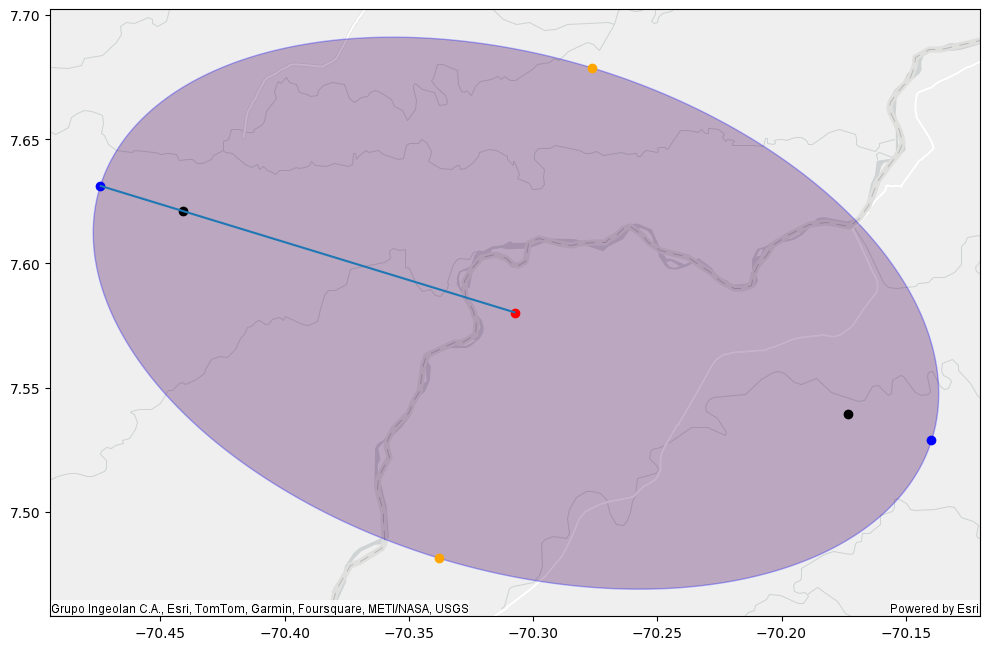

In [75]:
%%time
# id 119xxx is nearer equator; 258xxx is ~53N; 120xxx is FAST and near equator
# note that with the distortion in the plotted map, the locations farther from the equator get some interesting distortion
id = 1197896275 #1013238207  # 1197896275 # 258155363 # 1202739038

#PPA
plt = subdf.where(F.col(num_field) == id )\
    .st.plot(alpha=0.3, edgecolor="blue", basemap="light", cmap_values=id_field, geometry="geom_PPA", figsize=(12,12))

# current and previous location
subdf.where(F.col(num_field) == id)\
    .st.plot(color="black", geometry="point_current", ax=plt)

subdf.where(F.col(num_field) == id)\
    .st.plot(color="black", geometry="point_previous", ax=plt)

# midpoint
subdf.where(F.col(num_field) == id)\
    .st.plot(color="red", geometry="midpoint_point", ax=plt)

# major and minor axis points
subdf.where(F.col(num_field) == id)\
    .st.plot(color="blue", geometry="major_axis_point1", ax=plt)

subdf.where(F.col(num_field) == id)\
    .st.plot(color="blue", geometry="major_axis_point2", ax=plt)

subdf.where(F.col(num_field) == id)\
    .st.plot(color="orange", geometry="minor_axis_point2", ax=plt)

subdf.where(F.col(num_field) == id)\
    .st.plot(color="orange", geometry="minor_axis_point1", ax=plt)

# line from midpoint to one end of major axis
subdf.where(F.col(num_field) == id)\
    .select(ST.geodesic_shortest_line("midpoint_point", "major_axis_point1"))\
    .st.plot(ax=plt)

In [77]:
# # plotting 10,000 points as a sample
# plt = subdf.limit(10000)\
#     .st.plot(alpha=0.3, basemap="light", cmap_values=id_field, geometry="geom_PPA", legend=True)